In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun  8 11:20:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 10.0 MB/s 
     |████████████████████████████████| 965 kB 44.3 MB/s 
     |████████████████████████████████| 235 kB 19.5 MB/s 
     |████████████████████████████████| 581 kB 16.4 MB/s 


In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [ ]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [ ]:
train[train['sentence'].str.contains('. e12')]

,sentence,sentiment,topic


In [ ]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)

  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(sent)
      for token in tags:
        if token[0] not in punctuations:
          tokens.append(uncased(token[0]))
          pos_tags.append(f'{uncased(token[0])}|{token[1]}')
          
    return tokens,pos_tags

  norm_text=fix_whitespaces(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text)))))))).strip())
  return tokenizer(norm_text)

In [ ]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [ ]:
train_x=[normalizer(sample)for sample in train_x]

In [ ]:
train_x[0]

(['slide', 'giáo trình', 'đầy đủ'], ['slide|N', 'giáo trình|V', 'đầy đủ|A'])

In [ ]:
all_tokens=[s[0] for s in train_x]
all_tokens=list(chain.from_iterable(all_tokens))

In [ ]:
counter=Counter(all_tokens)

In [ ]:
counter.most_common(10)

[('thầy', 3048),
 ('sinh viên', 2684),
 ('dạy', 2162),
 ('và', 2068),
 ('không', 2058),
 ('rất', 1961),
 ('nhiệt tình', 1845),
 ('cho', 1724),
 ('có', 1708),
 ('nhiều', 1622)]

In [ ]:
x,y=list(range(1,len(counter)+1)),list(counter.values())


In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 3463, 1)

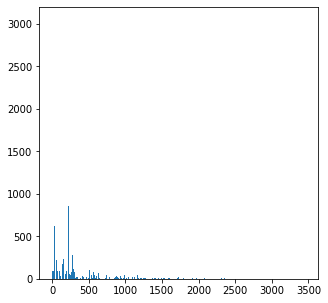

In [ ]:
seq_len_visualizer(x,y),max(x),min(x)

In [ ]:
all_pos_tags=[s[1] for s in train_x]
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [ ]:
counter=Counter(all_pos_tags)

In [ ]:
counter.most_common(10)

[('thầy|N', 3048),
 ('sinh viên|N', 2682),
 ('dạy|V', 2162),
 ('và|C', 2068),
 ('không|R', 2058),
 ('rất|R', 1961),
 ('có|V', 1702),
 ('nhiều|A', 1622),
 ('hiểu|V', 1568),
 ('cho|E', 1461)]

In [ ]:
x,y=list(range(1,len(counter)+1)),list(counter.values())

In [ ]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 4410, 1)

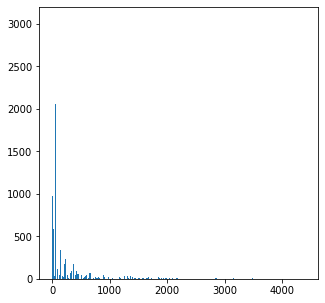

In [ ]:
seq_len_visualizer(x,y),max(x),min(x)

#Train word2vec

In [ ]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
w2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)
p2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [ ]:
word_sents=[sent[0] for sent in train_x]
pos_sents=[sent[1] for sent in train_x]

In [ ]:
w2v_model.build_vocab(word_sents)
p2v_model.build_vocab(pos_sents)

In [ ]:
w2v_model.train(word_sents, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)
p2v_model.train(pos_sents, total_examples=p2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7915813, 10918300)

In [ ]:
w2v_model.get_latest_training_loss(),p2v_model.get_latest_training_loss()

(21762924.0, 23340306.0)

In [ ]:
w2v_model.wv.most_similar(word_sents[0][0]),word_sents[0][0]

([('bài giảng', 0.9128121733665466),
  ('đọc', 0.9052721858024597),
  ('giáo trình', 0.898164689540863),
  ('giao tiếp', 0.8775270581245422),
  ('bằng', 0.8635618686676025),
  ('việt', 0.8610875606536865),
  ('rõ ràng', 0.8555132150650024),
  ('to', 0.8393564224243164),
  ('up', 0.8383626937866211),
  ('tăng cường', 0.837610125541687)],
 'slide')

In [ ]:
p2v_model.wv.most_similar(pos_sents[0][0]),pos_sents[0][0]

([('giao tiếp|V', 0.9173514246940613),
  ('đọc|V', 0.9166379570960999),
  ('giáo trình|N', 0.9164043664932251),
  ('bài giảng|V', 0.912919282913208),
  ('việt|V', 0.9071084260940552),
  ('slide|V', 0.8985075950622559),
  ('bằng|E', 0.8934258222579956),
  ('to|A', 0.8917434215545654),
  ('rõ ràng|A', 0.8900977373123169),
  ('luyện|V', 0.8878583908081055)],
 'slide|N')

In [ ]:
wv=w2v_model.wv
pv=p2v_model.wv

In [ ]:
vocabs=['pad','unk']+list(wv.vocab.keys())
pos_tags=['pad','unk']+list(pv.vocab.keys())

In [ ]:
len(vocabs),len(pos_tags)

(3465, 4412)

In [ ]:
vocab2idx={vocab:idx for idx,vocab in enumerate(vocabs)}
pos2idx={pos:idx for idx,pos in enumerate(pos_tags)}

In [ ]:
vocab2idx['đầy đủ']

4

In [ ]:
w_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),wv.vectors],axis=0)
w_weights.shape

(3465, 300)

In [ ]:
p_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),pv.vectors],axis=0)
p_weights.shape

(4412, 300)

#Create inputs

In [ ]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens,pos_tags=normalizer(sample)

  for i in zip(tokens,pos_tags):
    if i[0] in vocab2idx:
      _tokens.append(vocab2idx[i[0]])
    else:
      _tokens.append(vocab2idx['unk'])

    if i[1] in pos2idx:
      _pos_tags.append(pos2idx[i[1]])
    else:
      _pos_tags.append(pos2idx['unk'])

  return _tokens,_pos_tags

In [ ]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [ ]:
create_input_ids(train_x[0]),train_x[0]

(([2, 3, 4], [2, 3, 4]), 'slide giáo trình đầy đủ .')

In [ ]:
train_x=[create_input_ids(s) for s in train_x]

In [ ]:
words_train_x=[s[0] for s in train_x]
pos_tags_train_x=[s[1] for s in train_x]

In [ ]:
max_length=128

In [ ]:
words_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_train_x, padding="post",maxlen=max_length)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=max_length)

In [ ]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [ ]:
valid_x=[create_input_ids(s) for s in valid_x]

In [ ]:
words_valid_x=[s[0] for s in valid_x]
pos_tags_valid_x=[s[1] for s in valid_x]

In [ ]:
words_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_valid_x, padding="post",maxlen=max_length)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=max_length)

In [484]:
train_batch_size=16
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_train_x,'pos_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [485]:
valid_batch_size=16
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_valid_x,'pos_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

#Define model

In [486]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [531]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [532]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,drop_rate=0.1,word_embedding_weights=None,pos_embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.num_pos_tags=num_pos_tags
    self.word_embedding_weights=word_embedding_weights
    self.pos_embedding_weights=pos_embedding_weights

    if self.word_embedding_weights is not None:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.word_embedding_weights),trainable=True)
    else:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)

    if self.pos_embedding_weights is not None:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.pos_embedding_weights),trainable=True)
    else:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True)

    # self.embedding_layer=layers.Concatenate(axis=-1)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_ids,training=False):

    #shape of x: (batch_size,seq_len)

    word_embedding=self.word_embedding_layer(input_ids)
    pos_embedding=self.pos_embedding_layer(pos_ids)
    # embedding_inputs=self.embedding_layer([word_embedding,pos_embedding])
    embedding_inputs=word_embedding+pos_embedding


    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_outputs=self.bi_lstm_layer(embedding_inputs)
    
    bi_lstm_outputs=self.dropout_layer(bi_lstm_outputs,training=training)

    logits=self.linear(bi_lstm_outputs)

    return logits

    

In [503]:
embedding_dim=300
hidden_dim=256
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.2

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate,word_embedding_weights=w_weights,pos_embedding_weights=p_weights)

In [ ]:
batch['input_ids']

In [504]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 64, 101,  93, ...,   0,   0,   0],
       [105,  22,   9, ...,   0,   0,   0],
       [118, 119, 120, ...,   0,   0,   0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 64, 102,  94, ...,   0,   0,   0],
       [106, 107,   9, ...,   0,   0,   0],
       [120, 121, 122, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3], dtype=int32)>}


In [505]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[   3,   15,  154, ...,    0,    0,    0],
       [  25,  283,    0, ...,    0,    0,    0],
       [ 304,  280,  226, ...,    0,    0,    0],
       ...,
       [ 466, 1055,    0, ...,    0,    0,    0],
       [ 114,   76,  728, ...,    0,    0,    0],
       [ 214,   90,  198, ...,    0,    0,    0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[ 322,   15,  159, ...,    0,    0,    0],
       [ 235,  301,    0, ...,    0,    0,    0],
       [ 325,  298,  280, ...,    0,    0,    0],
       ...,
       [ 505, 1721,    0, ...,    0,    0,    0],
       [ 116,  153,  808, ...,    0,    0,    0],
       [ 225,   91, 1497, ...,    0,    0,    0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=int32)>}


In [506]:
lr=1e-5
epsilon=1e-8
# decay=0
optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

In [507]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [508]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [509]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [510]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_ids=pos_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss,probs

In [511]:
def test_step(input_ids,pos_ids,labels):
  logits= model(input_ids=input_ids,pos_ids=pos_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss,probs

In [534]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-22


#Train

In [513]:
epochs=100

In [514]:
# min_loss=np.inf
best_acc=0
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  y_true=[]
  y_pred=[]
  for batch in train_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=train_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    pred=tf.argmax(probs,axis=-1)
    
    y_pred.append(pred.numpy())
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  
  train_loss/=len(train_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  train_acc=accuracy_score(y_true,y_pred)

  """Validation"""
  valid_loss=0
  y_true=[]
  y_pred=[]
  for batch in valid_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=test_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    pred=tf.argmax(probs,axis=-1)
    y_pred.append(pred.numpy())
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  valid_acc=accuracy_score(y_true,y_pred)
  print(f'epoch: {epoch} train_loss: {train_loss} train_acc: {train_acc} valid_loss: {valid_loss} valid_acc: {valid_acc}')
  
  # if min_loss>valid_loss:
  if best_acc<valid_acc:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
    best_acc=valid_acc
    # min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accs.append(train_acc)
  valid_accs.append(valid_acc)

  if count_stopping>5:
    break

  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.8818300914097499 train_acc: 0.7061963941886925 valid_loss: 0.7942099035388291 valid_acc: 0.7271004421983576
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-1


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.7721536892694193 train_acc: 0.7180115525993348 valid_loss: 0.7389406757523315 valid_acc: 0.7264687302590019


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.7048930231507842 train_acc: 0.7313145457727989 valid_loss: 0.6695386770397725 valid_acc: 0.7334175615919141
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-2


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.634438951907458 train_acc: 0.7539821459828462 valid_loss: 0.6112256295452214 valid_acc: 0.7694251421351863
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-3


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.5823966634857071 train_acc: 0.7798879747943287 valid_loss: 0.5744630369273099 valid_acc: 0.7763739734680986
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-4


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.545474403262972 train_acc: 0.7920532119726938 valid_loss: 0.5472237007184462 valid_acc: 0.7877447883765003
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-5


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.5162463894361382 train_acc: 0.8043934885349203 valid_loss: 0.5264039721452829 valid_acc: 0.7946936197094125
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-6


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.49320606341311984 train_acc: 0.8109574654297217 valid_loss: 0.5070456212217157 valid_acc: 0.7997473152242578
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-7


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.47071372712408743 train_acc: 0.8183091195518992 valid_loss: 0.4921642447812389 valid_acc: 0.8066961465571699
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-8


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.4531047674325796 train_acc: 0.8257482933660073 valid_loss: 0.47807763276076076 valid_acc: 0.815540113708149
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-9


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.4371912109893519 train_acc: 0.8330124277962542 valid_loss: 0.4660783215153097 valid_acc: 0.8161718256475048
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-10


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.4247157303915991 train_acc: 0.8401890425345703 valid_loss: 0.45479869752219226 valid_acc: 0.8237523689197725
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-11


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.40819871834108046 train_acc: 0.8478907754244706 valid_loss: 0.4461561441421509 valid_acc: 0.8281743524952622
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-12


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.3962703262332019 train_acc: 0.8534045160161037 valid_loss: 0.4379142045673698 valid_acc: 0.83575489576753
Saving checkpoint for epoch 13 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-13


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.3851648429213287 train_acc: 0.860231051986697 valid_loss: 0.43078195198316765 valid_acc: 0.8389134554643083
Saving checkpoint for epoch 14 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-14


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.37464408243035935 train_acc: 0.8636443199719936 valid_loss: 0.4244339521786179 valid_acc: 0.8427037271004422
Saving checkpoint for epoch 15 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-15


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.3657381550936432 train_acc: 0.8691580605636268 valid_loss: 0.41908632482242103 valid_acc: 0.8471257106759318
Saving checkpoint for epoch 16 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-16


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.3559377995091718 train_acc: 0.8723962891650622 valid_loss: 0.41586966917972373 valid_acc: 0.8490208464939988
Saving checkpoint for epoch 17 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-17


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.34764839125784125 train_acc: 0.8778225100647645 valid_loss: 0.41300314213290357 valid_acc: 0.8509159823120657
Saving checkpoint for epoch 18 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-18


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.3388668592628482 train_acc: 0.8828986521967442 valid_loss: 0.41156958811210864 valid_acc: 0.8515476942514214
Saving checkpoint for epoch 19 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-19


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.3302539298923074 train_acc: 0.8849991248030807 valid_loss: 0.40927298630427833 valid_acc: 0.8490208464939988


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.3254347306005396 train_acc: 0.8883248730964467 valid_loss: 0.4078690154534398 valid_acc: 0.8540745420088439
Saving checkpoint for epoch 21 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-20


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.31787871105687604 train_acc: 0.8889375109399615 valid_loss: 0.4076818774520147 valid_acc: 0.8547062539481997
Saving checkpoint for epoch 22 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-21


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.31090018765388666 train_acc: 0.8940136530719411 valid_loss: 0.40594681201860155 valid_acc: 0.8515476942514214


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.30523240973169985 train_acc: 0.8943637318396639 valid_loss: 0.40407019364412383 valid_acc: 0.8597599494630449
Saving checkpoint for epoch 24 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-22


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.29906339466545756 train_acc: 0.8984771573604061 valid_loss: 0.4049856731235379 valid_acc: 0.8591282375236892


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.29043767520493563 train_acc: 0.9028531419569403 valid_loss: 0.4097174581779976 valid_acc: 0.8553379658875553


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.2854437214172595 train_acc: 0.904340976719762 valid_loss: 0.41032012758983505 valid_acc: 0.8566013897662665


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.28151026885188024 train_acc: 0.904603535795554 valid_loss: 0.40724719413603194 valid_acc: 0.8566013897662665


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.2753342123988729 train_acc: 0.9080168037808507 valid_loss: 0.404776073540702 valid_acc: 0.8597599494630449


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.2702349176578276 train_acc: 0.9109924733064939 valid_loss: 0.4132137130005191 valid_acc: 0.8540745420088439


#Visualize

In [519]:
def visualizer(x,y,y_label):
  fig,ax=plt.subplots(1,1)
  ax.plot(x)
  ax.plot(y)
  ax.set_xlabel('epoch')
  ax.set_ylabel(y_label)
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

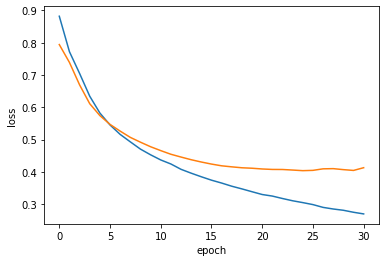

In [521]:
visualizer(train_losses,valid_losses,'loss')

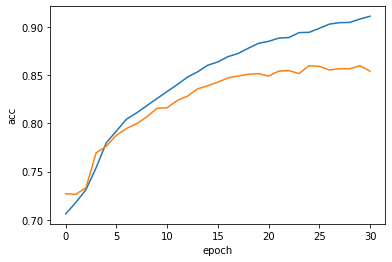

In [522]:
visualizer(train_accs,valid_accs,'acc')

#Inference

In [523]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [524]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [525]:
embedding_dim=300
hidden_dim=256
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.2

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate)

In [535]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [536]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-22


In [528]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:

  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i[0] for i in inputs],dtype=tf.int32)
  pos_ids=tf.constant([i[1] for i in inputs],dtype=tf.int32)

  
  
  logits=model(input_ids=input_ids,pos_ids=pos_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [529]:
print(classification_report(np.array(test_y),np.array(test_pred),digits=5))

              precision    recall  f1-score   support

           0    0.90376   0.93493   0.91908      2290
           1    0.60059   0.70979   0.65064       572
           2    0.92593   0.68966   0.79051       145
           3    0.84615   0.06918   0.12791       159

    accuracy                        0.83955      3166
   macro avg    0.81911   0.60089   0.62204      3166
weighted avg    0.84711   0.83955   0.82496      3166



In [530]:
confusion_matrix(test_y,test_pred)

array([[2141,  147,    0,    2],
       [ 161,  406,    5,    0],
       [   4,   41,  100,    0],
       [  63,   82,    3,   11]])

In [ ]:
for i in all_tokens:
  if i not in vocabs:
    print(i)

macbook|N
thầy số|V
số một|N
đươc|V
đơn|N
trước hết|N
toàn vẹn|V
dứt khoát|A
trống không|V
sách vở|N
cầu kỳ|N
tình huống|N
lở|V
tầm mắt|V
tạm thời|A
tồi tệ|N
good|V
đặc thù|V
ra sao|X
2014|N
omg|N
nguyên|A
vớt vát|V
cố chấp|N
giáo án|V
thu lượm|V
tạm|A
kỷ luật|N
vất vả|A
dạ|N
kiệm|N
liêm|N
mưa|V
tổng hợp|A
chú|Nc
hường|N
bơi|V
gật|V
thanks|N
cdio|V
thiệt thòi|V
nhè|V
cố định|A
chô|N
nguyên văn từ|N
